Epoch [1/15], Loss: 1.3727
Accuracy of the network on the 3000 validation images: 62.06666666666667 %
Epoch [2/15], Loss: 0.6050
Accuracy of the network on the 3000 validation images: 84.6 %
Epoch [3/15], Loss: 0.3541
Accuracy of the network on the 3000 validation images: 87.2 %
Epoch [4/15], Loss: 0.2535
Accuracy of the network on the 3000 validation images: 88.03333333333333 %
Epoch [5/15], Loss: 0.1610
Accuracy of the network on the 3000 validation images: 88.93333333333334 %
Epoch [6/15], Loss: 0.0993
Accuracy of the network on the 3000 validation images: 89.16666666666667 %
Epoch [7/15], Loss: 0.0607
Accuracy of the network on the 3000 validation images: 89.8 %
Epoch [8/15], Loss: 0.0300
Accuracy of the network on the 3000 validation images: 90.36666666666666 %
Epoch [9/15], Loss: 0.0129
Accuracy of the network on the 3000 validation images: 90.3 %
Epoch [10/15], Loss: 0.0054
Accuracy of the network on the 3000 validation images: 90.56666666666666 %
Epoch [11/15], Loss: 0.0027
Acc

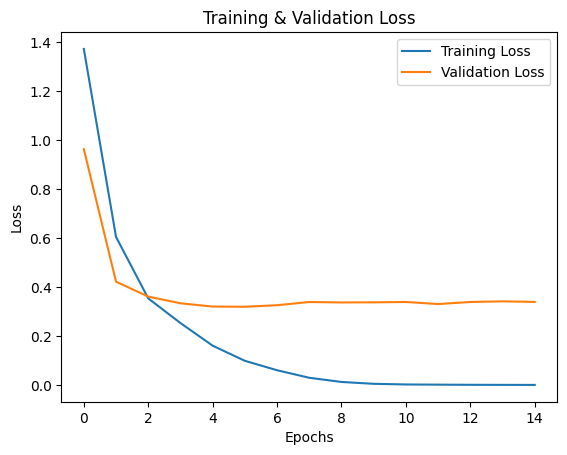

Accuracy of the network on the 1500 test images: 89.73333333333333 %


In [1]:
import torch.nn as nn
import torch
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((224,224)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data_dir = r'../input/doodles-images/Splited/train'

valid_data_dir = r'../input/doodles-images/Splited/val'

test_data_dir = r'../input/doodles-images/Splited/test'

train_data = datasets.ImageFolder(train_data_dir,transform = transform)

valid_data = datasets.ImageFolder(valid_data_dir,transform = transform)

test_data = datasets.ImageFolder(test_data_dir,transform = transform)

train_loader = torch.utils.data.DataLoader(train_data,
                                         batch_size=96,
                                         shuffle=True)

valid_loader = torch.utils.data.DataLoader(valid_data,
                                         batch_size=500,
                                         shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data,
                                         batch_size=500,
                                         shuffle=True)

class MobileNetV1(nn.Module):
    def __init__(self, ch_in, n_classes):
        super(MobileNetV1, self).__init__()
        
        def conv_bn(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, oup, 3, stride, 1),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True)
                )

        def conv_dw(inp, oup, stride):
            return nn.Sequential(
                # depth wise
                nn.Conv2d(inp, inp, 3, stride, 1, groups=inp), #(kernel_size, stride, padding)
                nn.BatchNorm2d(inp),
                nn.ReLU(inplace=True),
    
                # point wise
                nn.Conv2d(inp, oup, 1, 1, 0), #(kernel_size, stride, padding)
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True),
                )
            
        
        self.model = nn.Sequential(
            conv_bn(ch_in, 32, 2),      #(224, 224, 3) -> (112,112,32)   
            conv_dw(32, 64, 1),         #(112,112,32) -> (112,112,64)
            conv_dw(64, 128, 2),        #(112,112,64) -> (56,56,128)
            conv_dw(128, 128, 1),       #(56,56,128) -> (56,56,128)
            conv_dw(128, 256, 2),       #(56,56,128) -> (28,28,256)
            conv_dw(256, 256, 1),       #(28,28,256) -> (28,28,256)
            conv_dw(256, 512, 2),       #(28,28,256) -> (14,14,512) 
            conv_dw(512, 512, 1),       #(14,14,512) -> (14,14,512)
            conv_dw(512, 512, 1),       #(14,14,512) -> (14,14,512) 
            conv_dw(512, 512, 1),       #(14,14,512) -> (14,14,512) 
            conv_dw(512, 512, 1),       #(14,14,512) -> (14,14,512) 
            conv_dw(512, 512, 1),       #(14,14,512) -> (14,14,512) 
            conv_dw(512, 1024, 2),      #(14,14,512) -> (7,7,1024)
            conv_dw(1024, 1024, 1),     #(7,7,1024) -> (7,7,1024)
            nn.AvgPool2d(7, stride=1)   # average (7,7)
        )
        self.fc = nn.Linear(1024, n_classes)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)    #flatten into 1024 values then put into FC
        x = self.fc(x)
        return x
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MobileNetV1(ch_in=3, n_classes=5).to(device)

num_epochs = 15
learning_rate = 0.006

#Loss and optimizer
criterion = nn.CrossEntropyLoss()

#weight_decay = L2 regularization with lambda = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)  

#Garbage Collector
import gc

graph = []

for epoch in range(num_epochs):
    total_train_loss = 0
    total_valid_loss = 0
    
    #Training process
    for i, data in enumerate(train_loader):  
        #Move tensors to the configured device
        images, labels = data
        optimizer.zero_grad()
            
        #Forward pass
        outputs = model(images.to(device))
        loss = criterion(outputs, labels.to(device))
        
        total_train_loss += loss.item() * images.size(0)
        #Backward and optimize
        loss.backward()
        optimizer.step()
        
        #Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels.to(device)).sum().item()
        train_acc = float(correct)/float(images.to(device).shape[0])

        #Clean
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
    
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, total_train_loss/10500)) 
    #Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            
            total_valid_loss += criterion(outputs, labels).item() * labels.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
        print('Accuracy of the network on the {} validation images: {} %'.format(3000, 100 * correct / total))
    
    total_train_loss = total_train_loss/10500
    total_valid_loss = total_valid_loss/3000
    
    graph.append((total_train_loss, total_valid_loss))
    check_point = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'Train - Valid': total_train_loss - total_valid_loss,
            'lr': learning_rate
            }
    torch.save(check_point, 'checkpoint{}.pt'.format(epoch+1))


plt.plot(graph, label = ['Training Loss','Validation Loss'])
# naming the x axis
plt.xlabel('Epochs')
# naming the y axis
plt.ylabel('Loss')
# giving a title to my graph
plt.title('Training & Validation Loss')
# show a legend on the plot
plt.legend()
plt.show()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(1500, 100 * correct / total))   